# Architecture experiments

### Imports

In [1]:
import os
os.chdir("..")
from MLP import MLP
from MLP.loss import MSE, CROSSENTROPY
from MLP.activation import Activation
from MLP.initialization import WeightInitialization
from sklearn.model_selection import train_test_split
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import random
from tqdm import tqdm
from functools import reduce

### Data enhancement

In [57]:
# Rotate
def rotate(pic):
    scale = 1.0
    rows, cols = pic.shape[:2]
    img = []
    angle = [-15,-10,-5, 5, 10, 15]
    center = (cols / 2, rows / 2)   # Take the midpoint of the image
    for a in angle:
        M = cv2.getRotationMatrix2D(center, a, scale)  # Get the rotation matrix of the image around a certain point
        pic = cv2.warpAffine(pic, M, (cols, rows), borderValue=(1, 1, 1))# cv2.warpAffine() The second parameter is the transformation matrix, and the third parameter is the size of the output image
        img.append(pic)
    return img

# Noise
def noise(pic):
    for i in range(20):
        pic[random.randint(0, pic.shape[0] - 1)][random.randint(0, pic.shape[1] - 1)] = 1 
    return pic
        # random.randint(a, b)
        # Used to generate an integer in the specified range. Among them, parameter a is the lower limit, parameter b is the upper limit, the generated random number n: a <= n <= b
        
def gaussian(pic):
    img = []
    temp = cv2.GaussianBlur(pic, (9, 9), 1.5)  #Gaussian Blur
    dst = cv2.blur(pic, (5, 5), (-1, -1))  #Mean Filter
    # cv2.GaussianBlur (image, convolution kernel, standard deviation)
    img.append(temp)
    img.append(dst)
    return img

# Illumination
def light(pic):
    img = []
    contrast = 1       #Contrast
    brightness = 1    #brightness
    pic_turn1 = cv2.addWeighted(pic,contrast,pic,0,brightness)
    pic_turn2 = cv2.addWeighted(pic, 1.5, pic, 0, 0.5)
    img.append(pic_turn1)
    img.append(pic_turn2)
    # cv2.addWeighted(object, contrast, object, contrast)
    #cv2.addWeighted() realizes the change of image transparency and the superposition of images
    return img

def move(pic):
    img = []
    h = random.randint(1,6)
    v = random.randint(1,6)
    x, y = pic.shape
    img.append(np.c_[np.zeros((x,h)), pic[:,:-h]])
    img.append(np.r_[np.zeros((v,y)), pic[:-v,:]])
    img.append(np.c_[pic[:,h:], np.zeros((x,h))])
    img.append(np.r_[pic[v:,:], np.zeros((v,y))])
    return img
    


In [32]:
test_size = 6000
train_size = 1000
weight_initialization = WeightInitialization.HE
random_seeds = [1234, 4321, 2021]
activation_function = Activation.TANH
loss_function = CROSSENTROPY
reg_L1 = 0
reg_L2 = 0
batch_size = 30
epochs = 100
learning_rate = 1e-2
momentum = 0.9

df: pd.DataFrame = pd.read_csv("MNIST/data/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,255,0,0,0,0,0,0
1,1,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
2,1,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
3,1,255,255,255,63,0,0,0,0,0,...,0,0,0,0,0,0,7,255,255,255
4,1,255,255,255,255,200,53,0,0,0,...,0,0,0,0,18,150,255,255,255,255


In [6]:
results = []
for i, row in tqdm(list(df.iterrows())):
    img = row.iloc[1:].values.reshape(28,28)/255
    temp = []
    temp += [img]
    temp += [img*0.95 + 0.05, img*0.9 + 0.1]
    temp += rotate(img)
    temp += [noise(img) for _ in range(4)]
    temp += gaussian(img)
    temp += light(img)
    temp += move(img)
    temp = [np.r_[row.label, (255*pic.reshape(-1)).astype(np.int16,copy=False)] for pic in temp]
    results += temp

100%|██████████| 42000/42000 [00:47<00:00, 883.91it/s]


714000

In [31]:
final_df = pd.DataFrame(columns = df.columns)
final_df.to_csv("MNIST/data/enhanced_train.csv", header=True, index=False)
with open("MNIST/data/enhanced_train.csv", "a") as f:
    for result in tqdm(results):
        print(np.array2string(result, max_line_width=100000, separator=",", floatmode="unique")[1:-1], file=f)

100%|██████████| 714000/714000 [23:29<00:00, 506.47it/s]  


### Experiment functions definition

In [33]:
def testdata_MLP_classification(data_m: np.ndarray,
                                target_m: np.ndarray,
                                test_size: int,
                                train_size:int,
                                hidden_layers: List[int],
                                weight_initialization: WeightInitialization,
                                random_seed: int,
                                activation_functions: List[Activation],
                                loss_function,
                                reg_L1: float,
                                reg_L2: float,
                                batch_size: int,
                                epochs: int,
                                learning_rate: float,
                                momentum: float,
                                show_plots: bool) -> Tuple[np.ndarray, np.ndarray]:

    data, test, y_train, y_test = train_test_split(data_m, target_m,
                                                   test_size=test_size,
                                                   train_size=train_size,
                                                   random_state=random_seed)

    data_max = np.max(data)

    data = data / data_max
    test = test / data_max

    # one hot encoding
    n_values = np.max(y_train) + 1
    target = np.eye(n_values)[y_train]
    test_target = np.eye(n_values)[y_test]

    mlp = MLP(data,
              target,
              hidden_layers=hidden_layers,
              weight_initialization=weight_initialization,
              random_seed=random_seed,
              activation_functions=activation_functions,
              problem_type=MLP.ProblemType.CLASSIFICATION,
              loss_function=loss_function)

    mlp.fit(reg_L1=reg_L1,
            reg_L2=reg_L2,
            batch_size=batch_size,
            epochs=epochs,
            learning_rate=learning_rate,
            momentum=momentum,
            test_data=test,
            test_target=test_target)

    y_test_predict = mlp.predict(test)
    accuracy = np.mean(y_test_predict == y_test)

    print(f"Classification accuracy: {np.mean(y_test_predict == y_test)}\n")

    if show_plots:
        mlp.visualize_architecture()
        mlp.scatter_classification(y_test, test)
        mlp.print_loss_by_epoch()
        plt.show()

    return mlp.loss_values, mlp.test_loss_values, mlp

### Experiment data

In [27]:
architectures = [
    [32],
    [32, 32],
    [32, 32, 32],
    [64],
    [64, 64],
    [64, 64, 64],
    [128],
    [128, 128, 128],
    [128, 64],
    [128, 64, 64],
    [128, 64, 32]
]

### Experiments

In [52]:
for hidden_layers in architectures:
    for random_seed in random_seeds:
        loss_values, loss_test_values, model =\
            testdata_MLP_classification(data_m=df.loc[:, df.columns != "label"].to_numpy(),
                                        target_m=df["label"].to_numpy(),
                                        test_size=test_size,
                                        train_size=train_size,
                                        hidden_layers=hidden_layers,
                                        weight_initialization=weight_initialization,
                                        random_seed=random_seed,
                                        activation_functions=[activation_function]*len(hidden_layers) + [Activation.SOFTMAX],
                                        loss_function=CROSSENTROPY,
                                        reg_L1=0,
                                        reg_L2=0,
                                        batch_size=batch_size,
                                        epochs=epochs,
                                        learning_rate=learning_rate,
                                        momentum=momentum,
                                        show_plots=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8748333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8788333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8888333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8795



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8756666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8846666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8753333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.873



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8848333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8748333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8791666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8915



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8721666666666666



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.879



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8881666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.876



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8843333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8896666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8766666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8788333333333334



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8846666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8815



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8803333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8901666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8793333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8831666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8906666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8776666666666667



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.883



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.891



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8813333333333333



  0%|          | 0/100 [00:00<?, ?it/s]

Classification accuracy: 0.8816666666666667



100%|██████████| 100/100 [00:15<00:00,  6.57it/s]


Classification accuracy: 0.892



In [44]:
a, b, c = testdata_MLP_classification(data_m=df.loc[:, df.columns != "label"].to_numpy(),
                                      target_m=df["label"].to_numpy(),
                                      test_size=40000,
                                      train_size=2000,
                                      hidden_layers=[128, 64, 32],
                                      weight_initialization=weight_initialization,
                                      random_seed=random_seed,
                                      activation_functions=[activation_function]*len(hidden_layers) + [Activation.SOFTMAX],
                                      loss_function=CROSSENTROPY,
                                      reg_L1=0,
                                      reg_L2=0,
                                      batch_size=batch_size,
                                      epochs=1000,
                                      learning_rate=1e-4,
                                      momentum=momentum,
                                      show_plots=False)

100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


Classification accuracy: 0.8997



In [51]:
df: pd.DataFrame = pd.read_csv("MNIST/data/enhanced_train.csv")
activation_function=Activation.RELU
weight_initialization=WeightInitialization.HE
batch_size=64
momentum=0.9
hidden_layers = [128, 64, 32]
d, e, f = testdata_MLP_classification(data_m=df.loc[:, df.columns != "label"].to_numpy(),
                                      target_m=df["label"].to_numpy(),
                                      test_size=680000,
                                      train_size=34000,
                                      hidden_layers=hidden_layers,
                                      weight_initialization=weight_initialization,
                                      random_seed=2137,
                                      activation_functions=[activation_function]*len(hidden_layers) + [Activation.SOFTMAX],
                                      loss_function=CROSSENTROPY,
                                      reg_L1=0,
                                      reg_L2=0,
                                      batch_size=64,
                                      epochs=20,
                                      learning_rate=5e-3,
                                      momentum=0.95,
                                      show_plots=False)

100%|██████████| 20/20 [39:52<00:00, 119.63s/it]


Classification accuracy: 0.9253014705882353



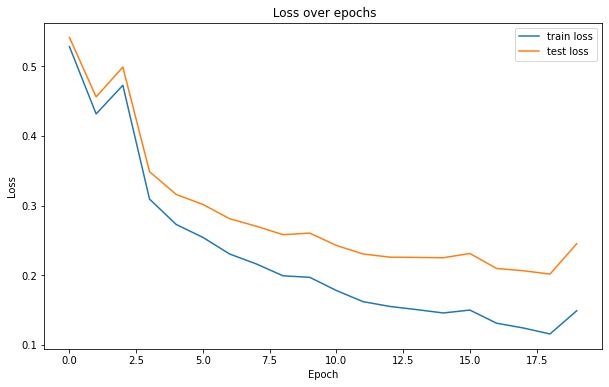

In [50]:
f.print_loss_by_epoch()

# Train for kaggle

In [5]:
# train for kaggle
df: pd.DataFrame = pd.read_csv("MNIST/data/enhanced_train.csv")
data = df.loc[:, df.columns != "label"].to_numpy()
data_max = np.max(data)
data = data / data_max

target = df["label"].to_numpy()
n_values = np.max(target) + 1
target = np.eye(n_values)[target]

activation_function=Activation.RELU
hidden_layers = [128, 64, 32]
activation_functions=[activation_function]*len(hidden_layers) + [Activation.SOFTMAX]
weight_initialization=WeightInitialization.HE
loss_function=CROSSENTROPY
batch_size=64
momentum=0.9
learning_rate=1e-3


mlp = MLP(data,
          target,
          hidden_layers=hidden_layers,
          weight_initialization=weight_initialization,
          random_seed=34,
          activation_functions=activation_functions,
          problem_type=MLP.ProblemType.CLASSIFICATION,
          loss_function=loss_function)

mlp.fit(reg_L1=0,
        reg_L2=0,
        batch_size=batch_size,
        epochs=50,
        learning_rate=learning_rate,
        momentum=momentum)

100%|██████████| 40/40 [3:27:50<00:00, 311.76s/it]  


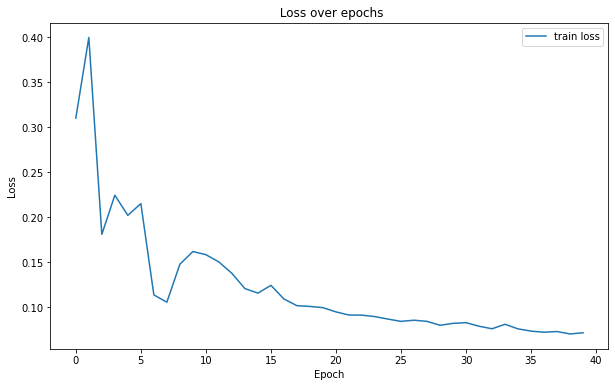

In [8]:
mlp.print_loss_by_epoch()

In [12]:
df_test: pd.DataFrame = pd.read_csv("MNIST/data/test.csv")
test = df_test.to_numpy()
test = test / data_max

In [13]:
predicted_values = mlp.predict(test)
df_test.loc[:,"label"] = predicted_values
results = df_test.loc[:,["label"]].reset_index()
results.columns = ["ImageId", "Label"]
results.loc[:,"ImageId"] += 1
results.to_csv("MNIST/data/submission.csv",header=True, index=False)